In [1]:
from pyecsca.ec.model import ShortWeierstrassModel, MontgomeryModel, TwistedEdwardsModel
from pyecsca.ec.formula_gen.test import load_efd_formulas, load_library_formulas
from pyecsca.ec.formula_gen.formula_graph import EFDFormulaGraph, rename_ivs
from pyecsca.ec.formula_gen.fliparoo import generate_fliparood_formulas, greedy_fliparoo, recursive_fliparoo
import pyecsca.ec.formula_gen.metrics as metrics
from pyecsca.ec.formula_gen.switch_sign import generate_switched_formulas
from tqdm.notebook import tqdm

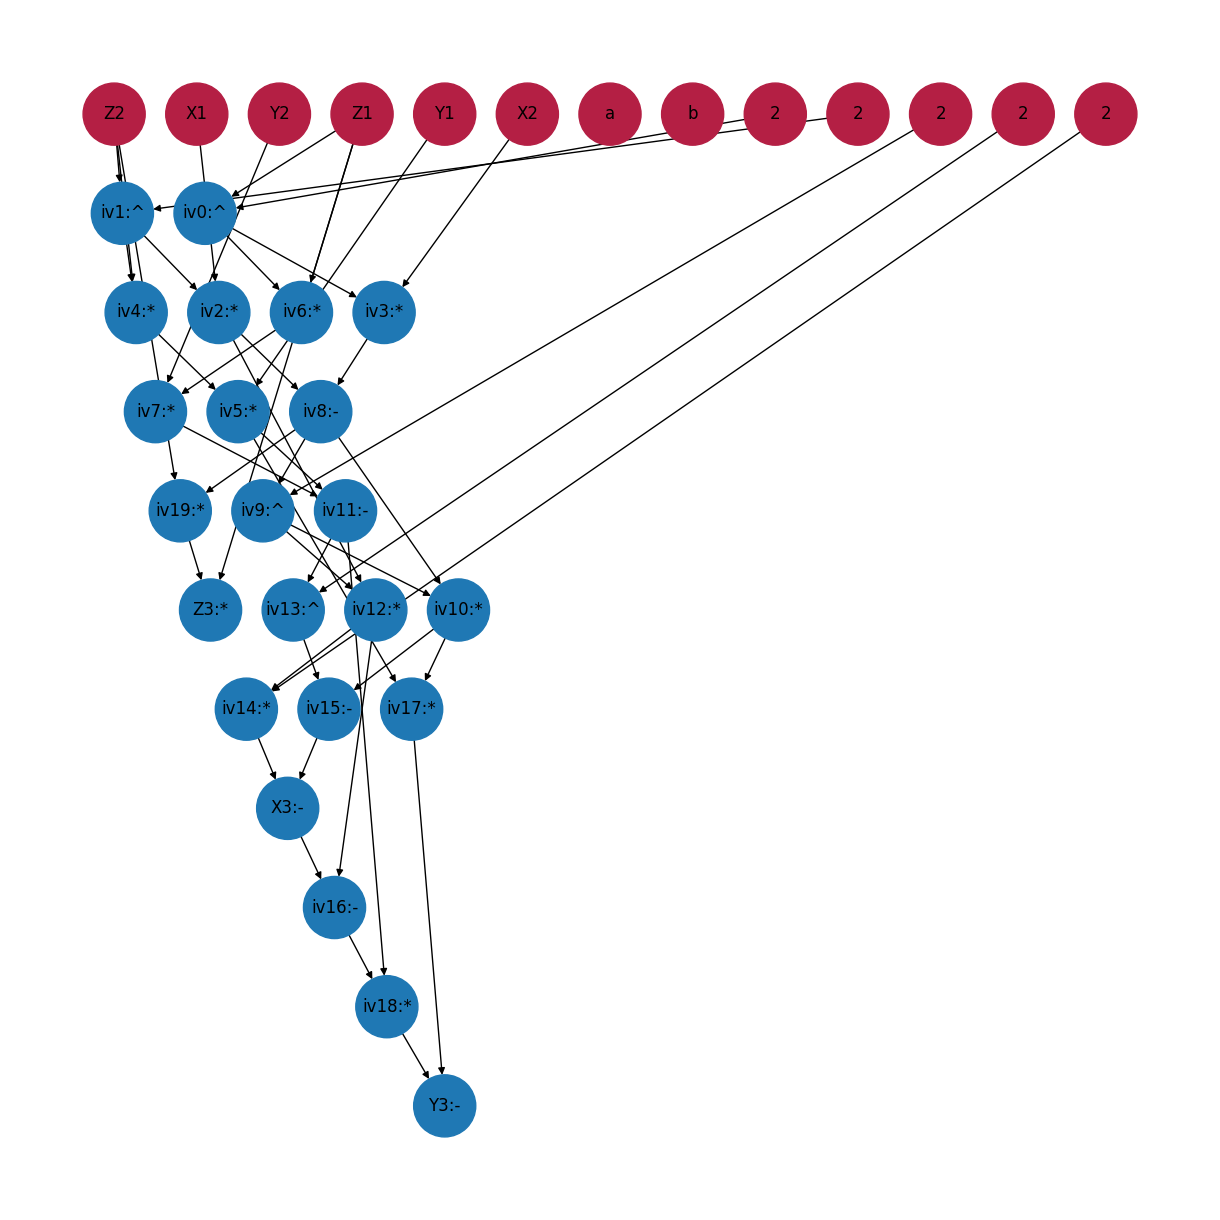

In [2]:
""" Draw formula """
coordinate_name = "jacobian"
model = ShortWeierstrassModel()
name = "add-1998-cmo-2"
formula = load_efd_formulas(coordinate_name,model)[name]
graph = EFDFormulaGraph()
graph.construct_graph(formula)
graph.draw()

In [ ]:
""" Draw all formulas """
coordinate_name = "jacobian"
model = ShortWeierstrassModel()
for name, formula in load_efd_formulas(coordinate_name,model).items():
    graph = EFDFormulaGraph()
    graph.construct_graph(formula)
    graph.draw(f"{coordinate_name}:{name}.png")

In [3]:
"""Measure similarity of fliparood formulas """
coordinate_name = "jacobian"
model = ShortWeierstrassModel()
name = "add-1998-cmo-2"
formula = load_efd_formulas(coordinate_name,model)[name]
for _,fliparood in generate_fliparood_formulas(formula):
    print(metrics.formula_similarity(formula,fliparood))

{'output': 1.0, 'ivs': 0.9565217391304348}
{'output': 1.0, 'ivs': 0.9565217391304348}
{'output': 1.0, 'ivs': 0.9565217391304348}
{'output': 1.0, 'ivs': 0.9565217391304348}
{'output': 1.0, 'ivs': 0.9565217391304348}
{'output': 1.0, 'ivs': 0.9565217391304348}
{'output': 1.0, 'ivs': 0.9565217391304348}


In [4]:
"""Greedy fliparoo to connect two formulas """
coordinate_name = "jacobian-3"
model = ShortWeierstrassModel()
name = "add-1998-cmo-2"
formula = load_efd_formulas(coordinate_name,model)[name]
lib_formula = load_library_formulas()["add-openssl-z256"]
metric = lambda x: metrics.formula_similarity(x,formula)["ivs"]
flips, closest, sim = greedy_fliparoo(lib_formula,metric)
print(f"Number of flips: {flips}, similarity: {sim}")

Number of flips: 2, similarity: 1.0


In [ ]:
""" Generate all fliparoos for efd formulas """
depth = 2
fliparood = {}
efd = load_efd_formulas("projective",ShortWeierstrassModel)
for name, formula in tqdm(efd.items()):
    fliparood[name] = recursive_fliparoo(formula,depth)


In [ ]:
""" Generate all switch-signed formulas for fliparoos formulas """
switch_signed = {}
for name, fliparoo_neighborhood in tqdm(fliparood.items()):
    switch_signed[name] = list()
    for chains,flip_f in fliparoo_neighborhood:
        switch_signed[name].extend((chains,s,f) for s,f in generate_switched_formulas(flip_f))

In [ ]:
""" Match library formulas for the expanded efd formulas"""
expanded_efd = sum(map(list,switch_signed.values()),[]) 
coordinates = "projective"
library_formulas = load_library_formulas(coordinates)

for name,formula in tqdm(library_formulas.items()):
    similarities = {}
    metric = lambda x: metrics.formula_similarity(x[2],formula)["ivs"]
    chains, switch, closest_efd = max(expanded_efd,key = metric)
    similarity = metric(closest_efd)
    print(f"{name}. Closest match: {closest_efd.name}, similarity={similarity}, fliparoos={len(chains)}, switches={len(switch)}")

In [3]:
import pickle
with open("jacobian","rb") as f:
    projective = pickle.load(f)

KeyboardInterrupt: 

In [6]:
projective['madd-2008-g'][1]

([],
 (Node(iv4 = X1-iv2), Node(iv5 = iv3-Y1)),
 AdditionEFDFormula(madd-2008-g for shortw/jacobian))

In [4]:

for name, formulas in projective.items():
    ivsets = []
    for _,_,formula in formulas:
        m = metrics.ivs_norm(formula)
        if not m in ivsets:
            ivsets.append(m)
    print(name,len(formulas),len(ivsets))

AttributeError: 'ShortWeierstrassModel' object has no attribute 'parameter_names'

In [6]:
ivsets = []
for name, formulas in projective.items():
    for _,_,formula in formulas:
        m = metrics.ivs_norm(formula)
        if not m in ivsets:
            ivsets.append(m)
    print(name,len(formulas))
print(len(ivsets))

add-2015-rcb 1171
madd-2015-rcb 146
add-2002-bj 85
mmadd-1998-cmo 26
add-1998-cmo-2 25
add-2007-bl 113
madd-1998-cmo 26
add-1998-cmo 1683
dbl-1998-cmo-2 25
dbl-2007-bl 16
dbl-2015-rcb 146
dbl-1998-cmo 49
mdbl-2007-bl 36
499


In [5]:
ShortWeierstrassModel().parameter_names

['a', 'b']